In [66]:
%matplotlib inline

In [67]:
import pandas as pd
import numpy as np
import cv2
import os


# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


Expected results for the top 5 most represented people in the dataset:

================== ============ ======= ========== =======
                   precision    recall  f1-score   support
================== ============ ======= ========== =======
     Ariel Sharon       0.67      0.92      0.77        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.86      0.86      0.86       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322
================== ============ ======= ========== =======




In [68]:
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [79]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays
photos = np.zeros(shape=(1,10000))
labels = []
target_names = []
sourcepath = "C://Users//DELL//Desktop//thesis//faceset"
i = 0
for filename in os.listdir(sourcepath):
    for number in os.listdir(sourcepath+"//"+filename):
        img = cv2.imread(sourcepath+"//"+filename+"//"+number)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(-1,)
        photos = np.insert(photos, photos.shape[0], values=img, axis=0)
        labels.append(i)
    target_names.append(filename)
    i = i + 1
photos=photos[1:]

In [72]:
filename

'Ariel_Sharon'

In [22]:
#lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [30]:
#type(lfw_people.data[1])

numpy.ndarray

In [8]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
#X = lfw_people.data
#n_features = X.shape[1]

In [10]:
#help(lfw_people)
#lfw_people.__getattr__
#lfw_people.__dir__
#show the whole picture of this bunch thing

In [34]:
#pd.Series(lfw_people.target).unique()

array([5, 6, 3, 1, 0, 4, 2], dtype=int64)

In [81]:
y = labels
X = photos

In [ ]:
# the label to predict is the id of the person

#target_names = lfw_people.target_names
#n_classes = target_names.shape[0]

#print("Total dataset size:")
#print("n_samples: %d" % n_samples)
#print("n_features: %d" % n_features)
#print("n_classes: %d" % n_classes)

In [82]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [83]:
h = 100
w = 100
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
#n has to be bigger than 12 including 12.
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, len(X_train)))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 951 faces
done in 2.926s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.292s


In [89]:
# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [2, 3, 4, 5, 6, 7, 8],
              'gamma': [0.0004, 0.0005, 0.0006], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 18.543s
Best estimator found by grid search:
SVC(C=3, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [90]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set
n_classes = len(target_names)
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
#the result is much better than the orginal way
#which is
#avg / total       0.80      0.80      0.80       322
#my result is 
#avg / total       0.90      0.89      0.89       318

Predicting people's names on the test set
done in 0.371s
                   precision    recall  f1-score   support

     Ariel_Sharon       0.83      0.88      0.86        17
     Colin_Powell       0.94      0.87      0.90        67
  Donald_Rumsfeld       0.93      0.88      0.90        32
    George_W_Bush       0.93      0.95      0.94       121
Gerhard_Schroeder       0.96      0.77      0.86        35
      Hugo_Chavez       0.47      0.78      0.58         9
       Tony_Blair       0.80      0.89      0.85        37

      avg / total       0.90      0.89      0.89       318

[[ 15   0   1   0   0   1   0]
 [  0  58   0   4   1   2   2]
 [  2   1  28   0   0   0   1]
 [  1   2   1 115   0   2   0]
 [  0   1   0   2  27   1   4]
 [  0   0   0   1   0   7   1]
 [  0   0   0   2   0   2  33]]


In [91]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

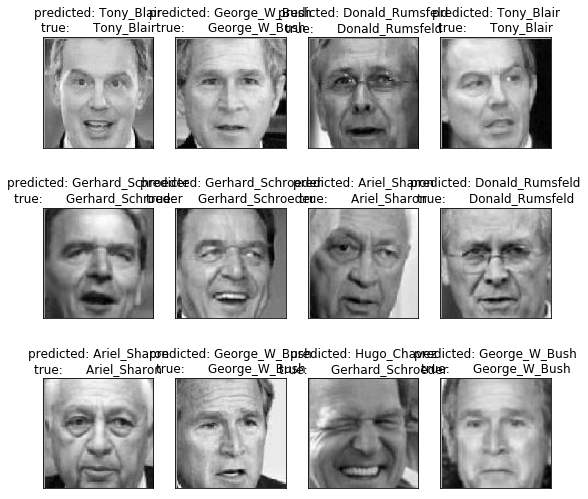

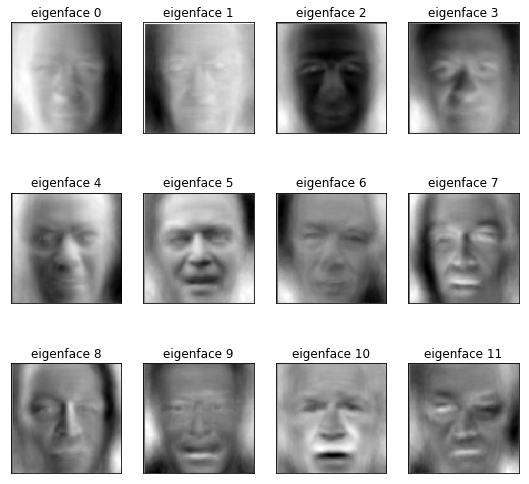

In [92]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]]
    true_name = target_names[y_test[i]]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 40 eigenfaces from 966 faces
done in 0.105s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
Fitting the classifier to the training set
done in 12.287s
Best estimator found by grid search:
SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.019s
                   precision    recall  f1-score   support

     Ariel Sharon       0.59      0.77      0.67        13
     Colin Powell       0.87      0.90      0.89        60
  Donald Rumsfeld       0.59      0.63      0.61        27
    George W Bush       0.91      0.86      0.89       146
Gerhard Schroeder       0.66      0.76      0.70        25
      Hugo Chavez       0.59      0.67      0.62        15


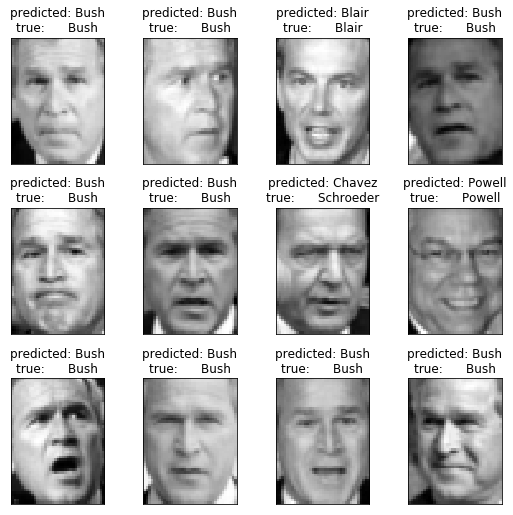

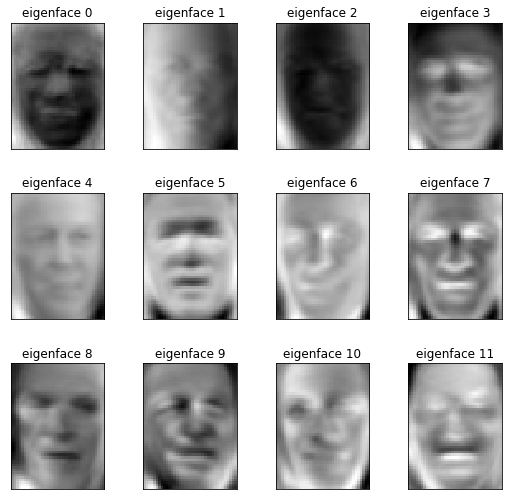